Import modul


In [1]:
#conda install -c saravji pmdarima

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
from datetime import date, timedelta

Penarikan data

In [2]:
# !pip install yfinance
KODE = 'BBNI.JK'
today_date = date.today()
td = timedelta(365)
mulai = today_date - td

import yfinance as yf
data = yf.download(KODE, start=mulai, end = today_date)
datam = yf.download(KODE, period="max", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


visualisasikan

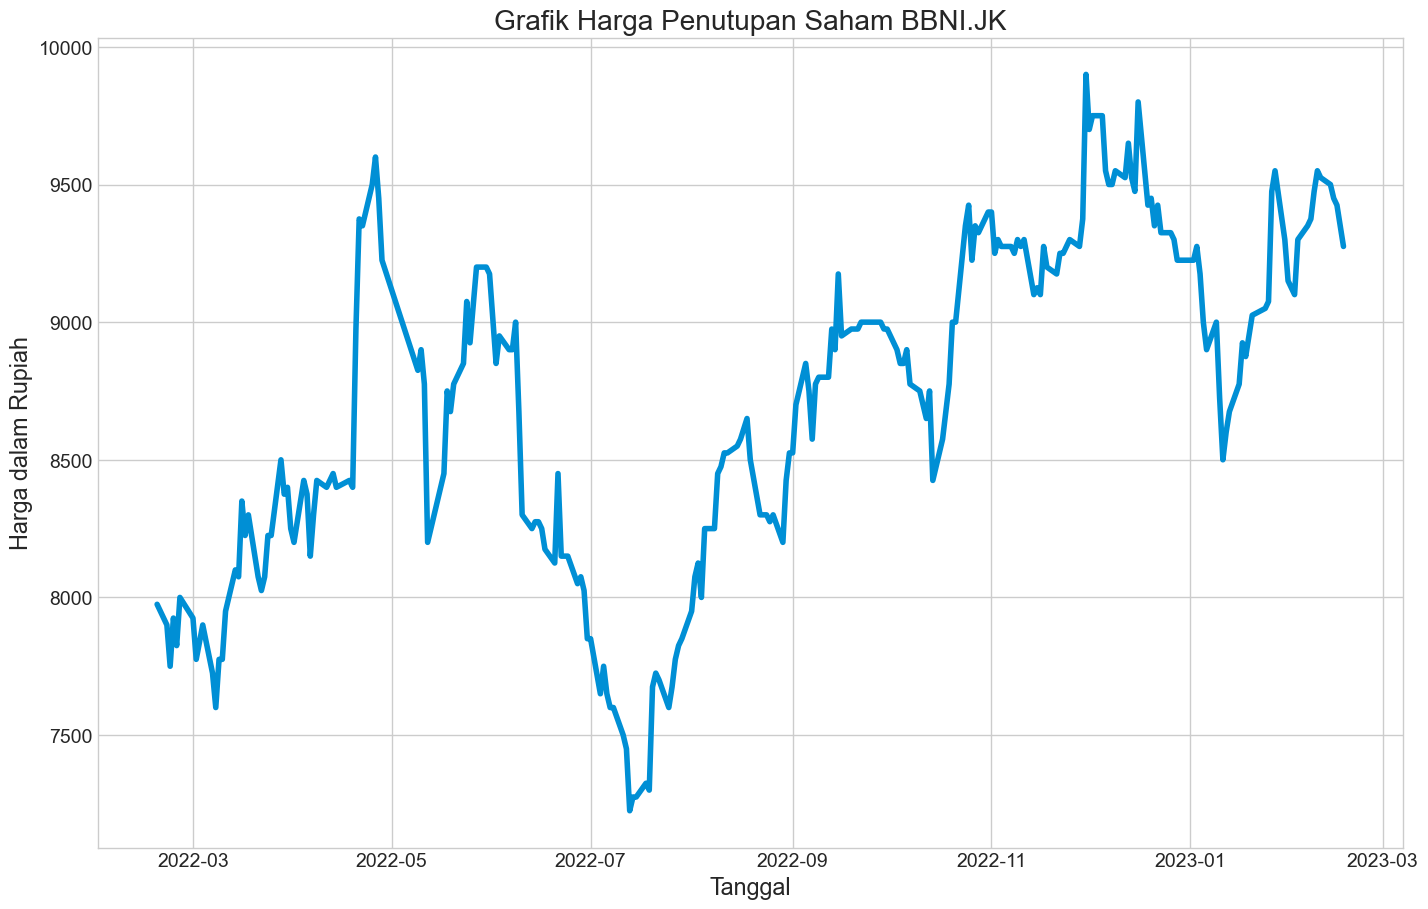

In [3]:
#plot harga penutupan
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,10))
plt.grid(True)
plt.xlabel('Tanggal')
plt.ylabel('Harga dalam Rupiah')
plt.plot(data['Close'])
plt.title('Grafik Harga Penutupan Saham '+KODE)
plt.show()

<AxesSubplot: ylabel='Density'>

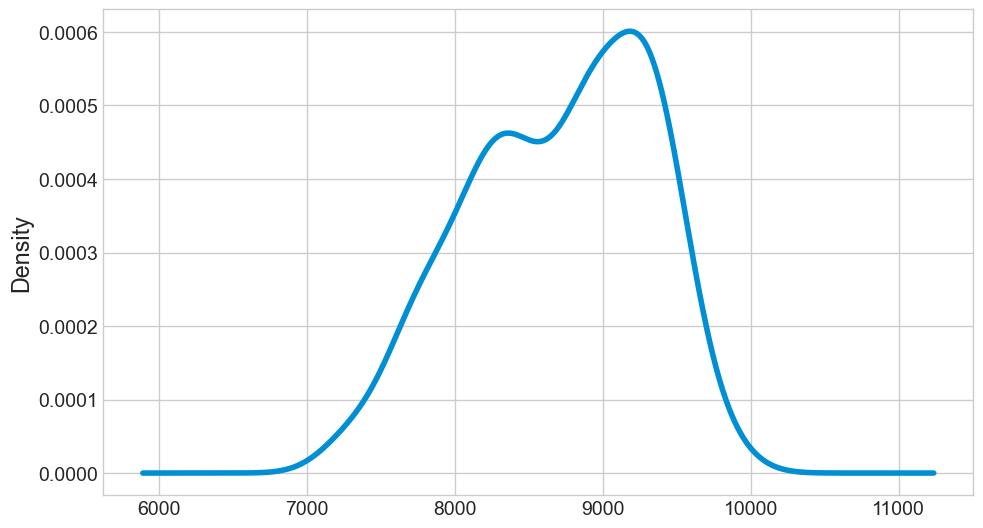

In [4]:
#Distribution of the dataset
df_close = data['Close']
df_close.plot(kind='kde')

Karena analisis deret waktu hanya bekerja dengan data stasioner, pertama-tama kita harus menentukan apakah deret itu stasioner.

Penggunaan ADF Test (Augmented Dickey-Fuller)
Salah satu uji statistik yang paling banyak digunakan adalah uji Dickey-Fuller. Ini dapat digunakan untuk menentukan apakah suatu deret memiliki akar satuan atau tidak, dan dengan demikian apakah deret tersebut stasioner atau tidak. Hipotesis nol dan alternatif tes ini adalah:

Hipotesis Null: Deret memiliki akar satuan (nilai a = 1)
Hipotesis Alternatif: Deret tidak memiliki akar satuan

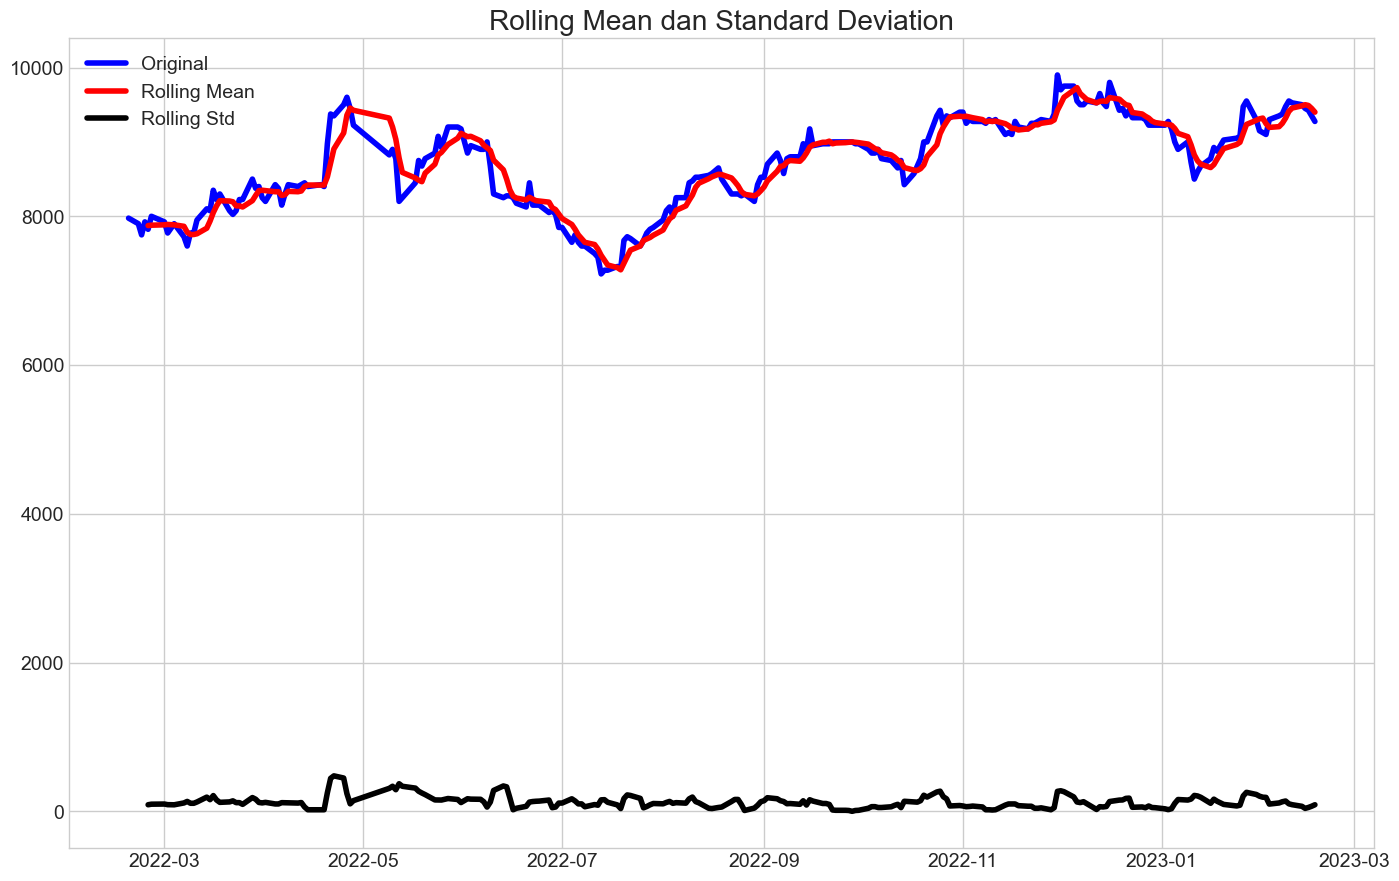

Results of dickey fuller test
Test Statistics                 -1.996030
p-value                          0.288317
No. of lags used                 0.000000
Number of observations used    246.000000
critical value (1%)             -3.457215
dtype: float64
Test Statistics                 -1.996030
p-value                          0.288317
No. of lags used                 0.000000
Number of observations used    246.000000
critical value (1%)             -3.457215
critical value (5%)             -2.873362
dtype: float64
Test Statistics                 -1.996030
p-value                          0.288317
No. of lags used                 0.000000
Number of observations used    246.000000
critical value (1%)             -3.457215
critical value (5%)             -2.873362
critical value (10%)            -2.573070
dtype: float64


In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#Test untuk staionarity
def test_stationarity(timeseries):
#Determinasi rolling statistics
    warnings.filterwarnings('ignore')
    rolmean = timeseries.rolling(5).mean()
    rolstd = timeseries.rolling(5).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn-whitegrid')
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean dan Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] = values
        print(output)

test_stationarity(df_close)

musiman dan tren mungkin perlu dipisahkan dari rangkaian data tersebut sebelum dilakukan analisis rangkaian deret waktu atau time series analysis. Pendekatan ini akan menyebabkan seri yang dihasilkan menjadi stagnan. Berikut pemisahkan deret waktu dari Tren dan Musiman dengan perintah seasonal_decompose:

<Figure size 800x550 with 0 Axes>

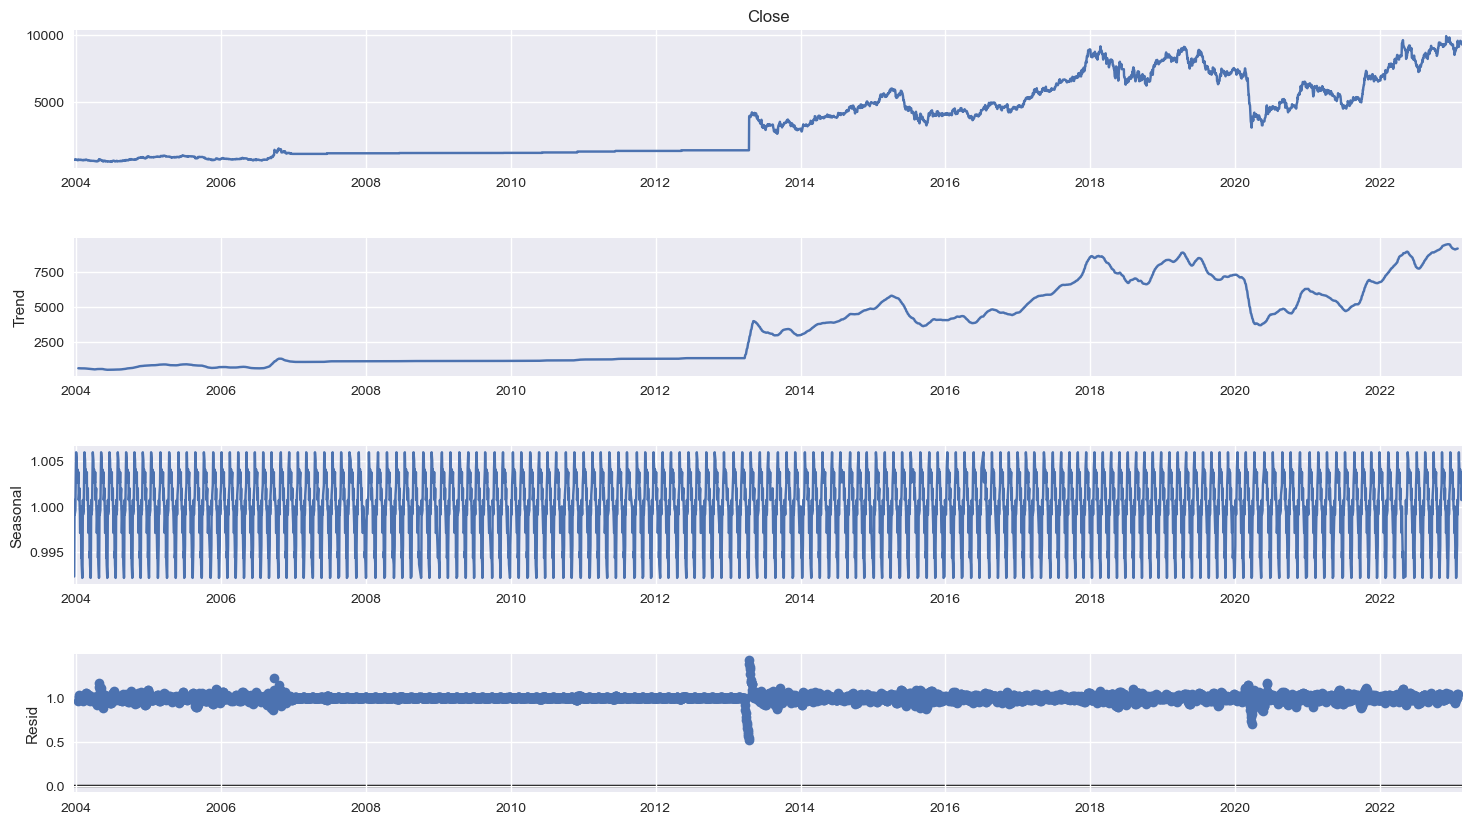

In [6]:
df_close = datam['Close']
df_open = datam['Open']
df_high = datam['High']
df_low = datam['Low']
df_volume = datam['Volume']

#result = seasonal_decompose(df_close, model='multiplicative', freq=30)
result = seasonal_decompose(df_close, model='multiplicative', period=30)
plt.style.use('seaborn')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Rata-rata bergulir (Moving Avarage) kemudian dihitung dengan mengambil data dari 12 bulan sebelumnya dan hitung nilai konsumsi rata-rata pada setiap titik berikutnya dalam rangkaian data seri tersebut

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


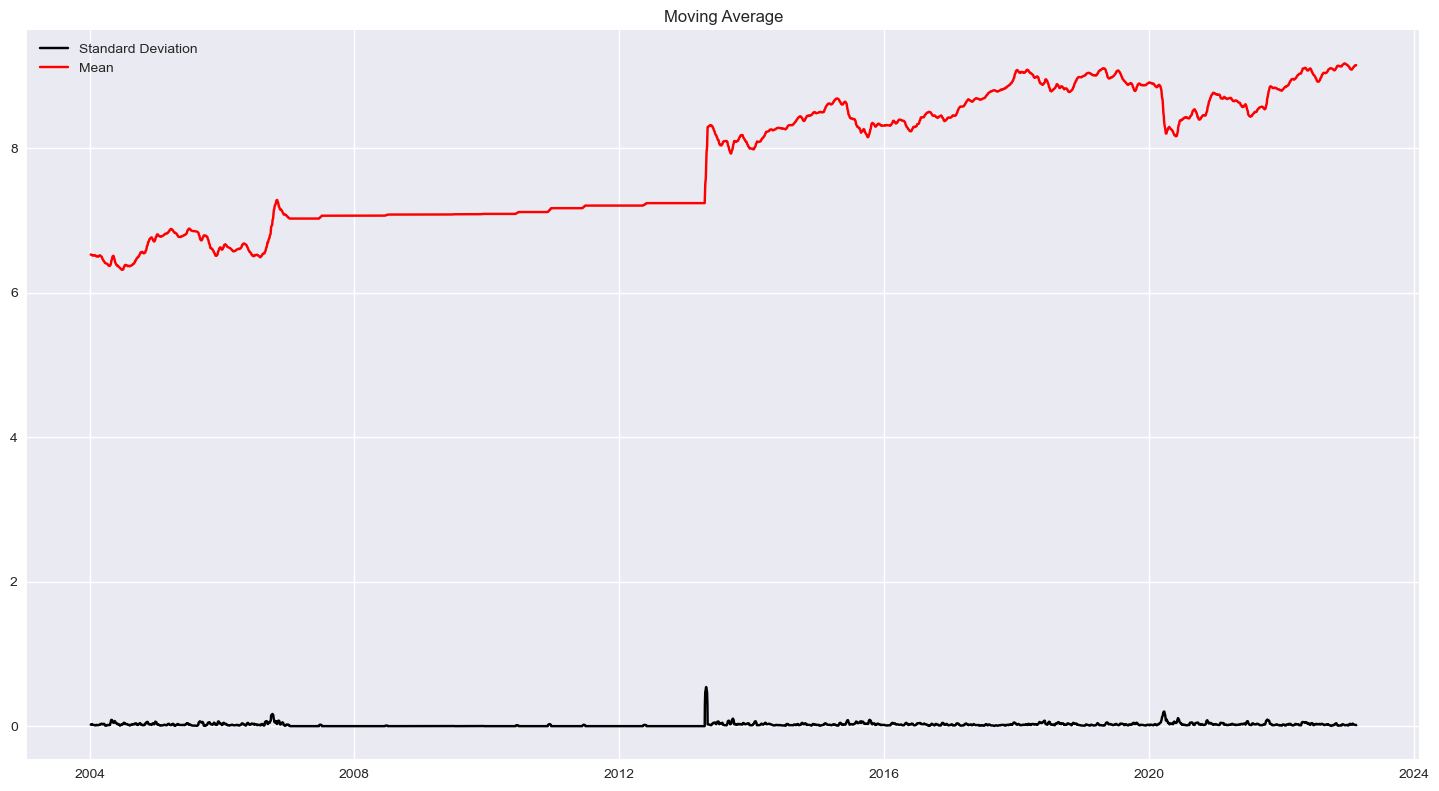

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

df_log = np.log(df_close)
df_log_open = np.log(df_open)
df_log_low = np.log(df_low)
df_log_high = np.log(df_high)
df_log_volume = np.log(df_volume)

moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend(loc='best')
plt.show()

Sekarang akan dikembangkan model ARIMA dan melatihnya menggunakan harga penutupan saham dari data train. Kemudian divisualisasikan data tersebut dengan membaginya menjadi set data train dan data pengujian (data test).

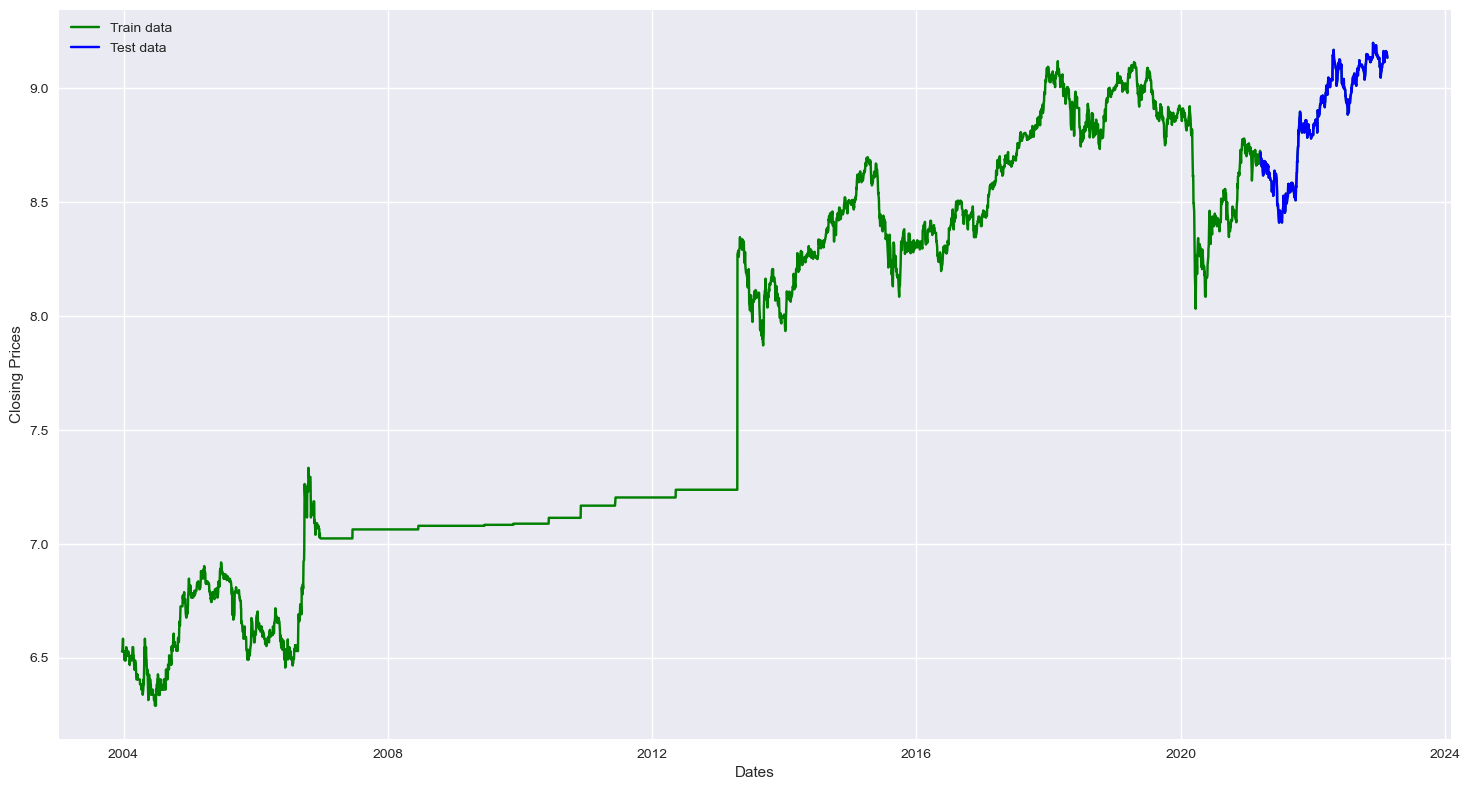

In [8]:
#split data jadi data train dan data training
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(16,9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


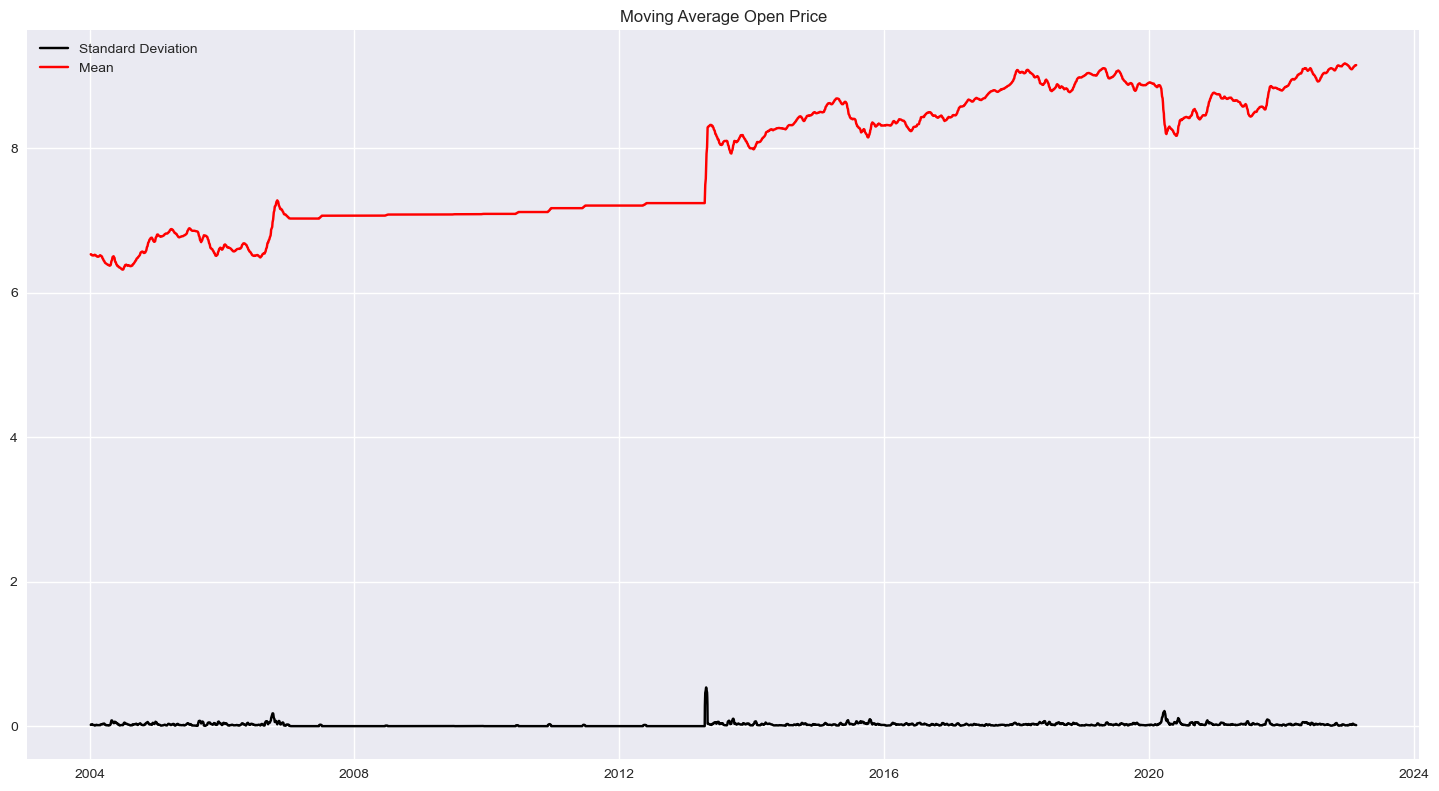

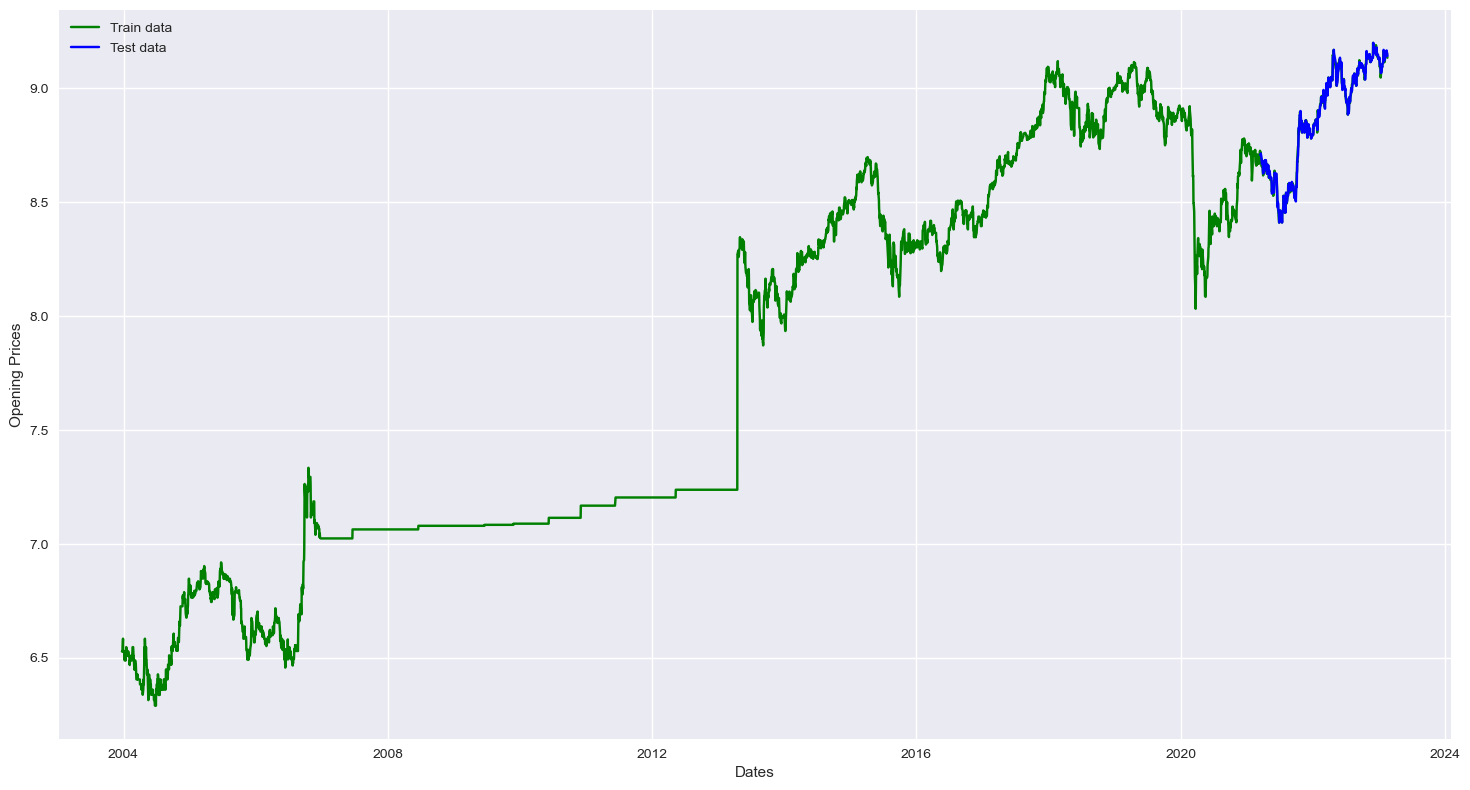

In [9]:
#data open
moving_avg = df_log_open.rolling(12).mean()
std_dev = df_log_open.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average Open Price')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend(loc='best')
plt.show()
#split data jadi data train dan data training
train_data, test_data = df_log_open[3:int(len(df_log_open)*0.9)], df_log_open[int(len(df_log)*0.9):]
plt.figure(figsize=(16,9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


model auto arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19776.240, Time=2.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-19775.281, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-19775.262, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-19776.307, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-19773.308, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.683 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4281
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9889.153
Date:                Sat, 18 Feb 2023   AIC                         -19776.307
Time:                        00:00:16   BIC                         -19769.945
Sample:                             0   HQIC                        -19774.059
                               - 4281                             

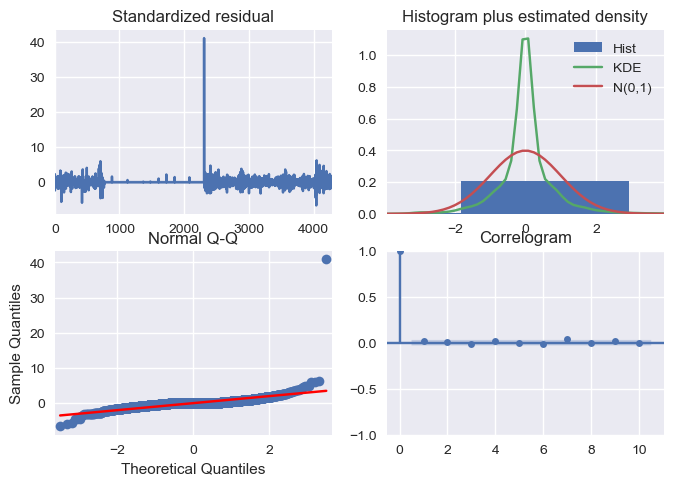

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf', # gunakan adf test untuk mencari nilai optimal 'd'
max_p=3, max_q=3, # maximum p dan q
m=1, # frequency dari data series
d=None, # Biarkan model untuk 'd' none
seasonal=False, # Tidak ada data musiman
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(7,5))
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,0,0))
fitted = model.fit()

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4281
Model:                 ARIMA(1, 0, 0)   Log Likelihood                9887.925
Date:                Sat, 18 Feb 2023   AIC                         -19769.849
Time:                        00:00:18   BIC                         -19750.764
Sample:                             0   HQIC                        -19763.107
                               - 4281                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7081      0.514     14.990      0.000       6.700       8.716
ar.L1          0.9995      0.000   2090.658      0.000       0.999       1.000
sigma2         0.0006   7.44e-07    774.024      0.0

# Forecast
fc, se, conf = fitted.forecast(test_data.shape[0], alpha=0.05) # 95% confidence

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(16,9), dpi=100)
plt.style.use('bmh')
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
color='k', alpha=.10)

plt.title('Prediction Harga Saham' + KODE)
plt.xlabel('Tanggal Transaksi')
plt.ylabel('Harga Saham')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [12]:
prediction  = fitted.forecast(steps=2)
prediction

4281    8.709927
4282    8.709460
Name: predicted_mean, dtype: float64